In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from sklearn.metrics         import mean_squared_error
from sklearn.tree            import DecisionTreeRegressor
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample
from sklearn.ensemble        import AdaBoostRegressor

In [2]:
# local file paths

dir_name = 'selezione'
region_names = np.array(['A', 'B', 'C'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 48)
X_valC:   (21908, 48)
X_testC:  (21876, 48)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



# Costruzione DecisionTreeRegressor #

In [6]:
plt.rcParams.update({'font.size': 35})

In [7]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [8]:
# Costruzione Decision TreeRegressor
def DecisionTreeRegressor_validation(X_train, y_train, X_val, y_val, verbose=False, debug=False, file_name=''):
    
    def get_dec_tree_reg(max_leaf):
        dt = DecisionTreeRegressor(max_leaf_nodes=max_leaf)
        dt.fit(X_train,y_train)
        return dt
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'TUNING DEL MASSIMO NUMERO DI FOGLIE {name}')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = np.argmin(stats[n]) + start
            
            print (f'Punteggio finale: {stats[n][-1]} ({end}) stimatori')
            print (f'Best {n}: {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(start, end+1),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(start, end+1),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(start, end+1),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name} MSE, BIAS, VARIANCE on differe Estimators", fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_' + name + '_DTR.jpg')
        
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()

    start =   2
    end   =  100
    
    model_start = get_dec_tree_reg(start)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_max_leaf = start
    best_model      = model_start
    
    info         = []
    
    train_stats  = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    val_stats    = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    } 
    
    for max_leaf in range(start, end+1):
        
        if debug:
            print(f'{max_leaf}/{end}')
    
        model = get_dec_tree_reg(max_leaf)
        
        trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, model)
        val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, model)

        train_stats['bias'].append(trn_bias)
        train_stats['var' ].append(trn_var )
        train_stats['mse' ].append(trn_mse )
        
        val_stats['bias'].append(val_bias)
        val_stats['var' ].append(val_var )
        val_stats['mse' ].append(val_mse )
        
        info.append(f'Max Leaf: {max_leaf}' +\
                    f'\n(Train MSE:       {trn_mse }  - Val MSE:      {val_mse })' +\
                    f'\n(Train Bias:      {trn_bias}  - Val Bias:     {val_bias})' +\
                    f'\n(Train Variance:  {trn_var }  - Val Variance: {val_var })' )

        if(val_mse < best_mse):
            best_mse = val_mse
            best_max_leaf = max_leaf
            best_model = model
    
    if verbose:
        print()
        print("MSE, BIAS, VARIANCE Train e Validation")
        print(*info, sep='\n')
        print()
        
    plot_mse(train_stats, "TRAIN"     )
    plot_mse(  val_stats, "VALIDATION")
                
    return best_model

In [9]:
#sub_perc = [   1/3,     1,    1/4] # circa 8000
#sub_perc = [     1,     1,    2/5] # A e B uguali, C circa 30000
sub_perc = [1/1000, 1/100, 1/1000] # circa 100, per testing
#sub_perc = [     1,     1,      1] # dataset completo

In [10]:
for i in range(3):
    print(int(len(X_train[i])*sub_perc[i]))
    print(int(len(X_val  [i])*sub_perc[i]))
    print()

26
9

81
26

64
21



In [11]:
X_train_sub = []
y_train_sub = []
X_val_sub = []
y_val_sub = []

In [12]:
for i in range(3):
    Xt_sub, yt_sub = resample(X_train[i], y_train[i], n_samples = int(sub_perc[i]*len(X_train[i])))
    Xv_sub, yv_sub = resample(X_val  [i], y_val  [i], n_samples = int(sub_perc[i]*len(X_val[i])))
    X_train_sub.append(Xt_sub)
    y_train_sub.append(yt_sub)
    X_val_sub  .append(Xv_sub)
    y_val_sub  .append(yv_sub)

In [13]:
for i in range(3):
    print(len(X_train_sub[i]))
    print(len(X_val_sub  [i]))
    print()

26
9

81
26

64
21



In [14]:
dt_model = []

In [15]:
def get_dt(index, verbose=False, debug=False, file_name=''):
    return DecisionTreeRegressor_validation(
        X_train_sub[index],\
        y_train_sub[index],\
        X_val_sub  [index],\
        y_val_sub  [index],\
        verbose   = verbose,\
        debug     = debug,\
        file_name = file_name
    )

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.01028986202383009 (100) stimatori
Best mse: 0.007374927903322706
Best number of Estimators: 2

Punteggio finale: 0.005144931011915045 (100) stimatori
Best bias: 0.005144931011915044
Best number of Estimators: 14

Punteggio finale: 0.005144931011915045 (100) stimatori
Best var: 0.0022299968914076583
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.0028156368239900262 (100) stimatori
Best mse: 0.0014983542939478393
Best number of Estimators: 97

Punteggio finale: 0.00177718074316907 (100) stimatori
Best bias: 0.001009364346878237
Best number of Estimators: 50

Punteggio finale: 0.0010384560808209566 (100) stimatori
Best var: 0.00013018248080763246
Best number of Estimators: 4

Wall time: 9.65 s


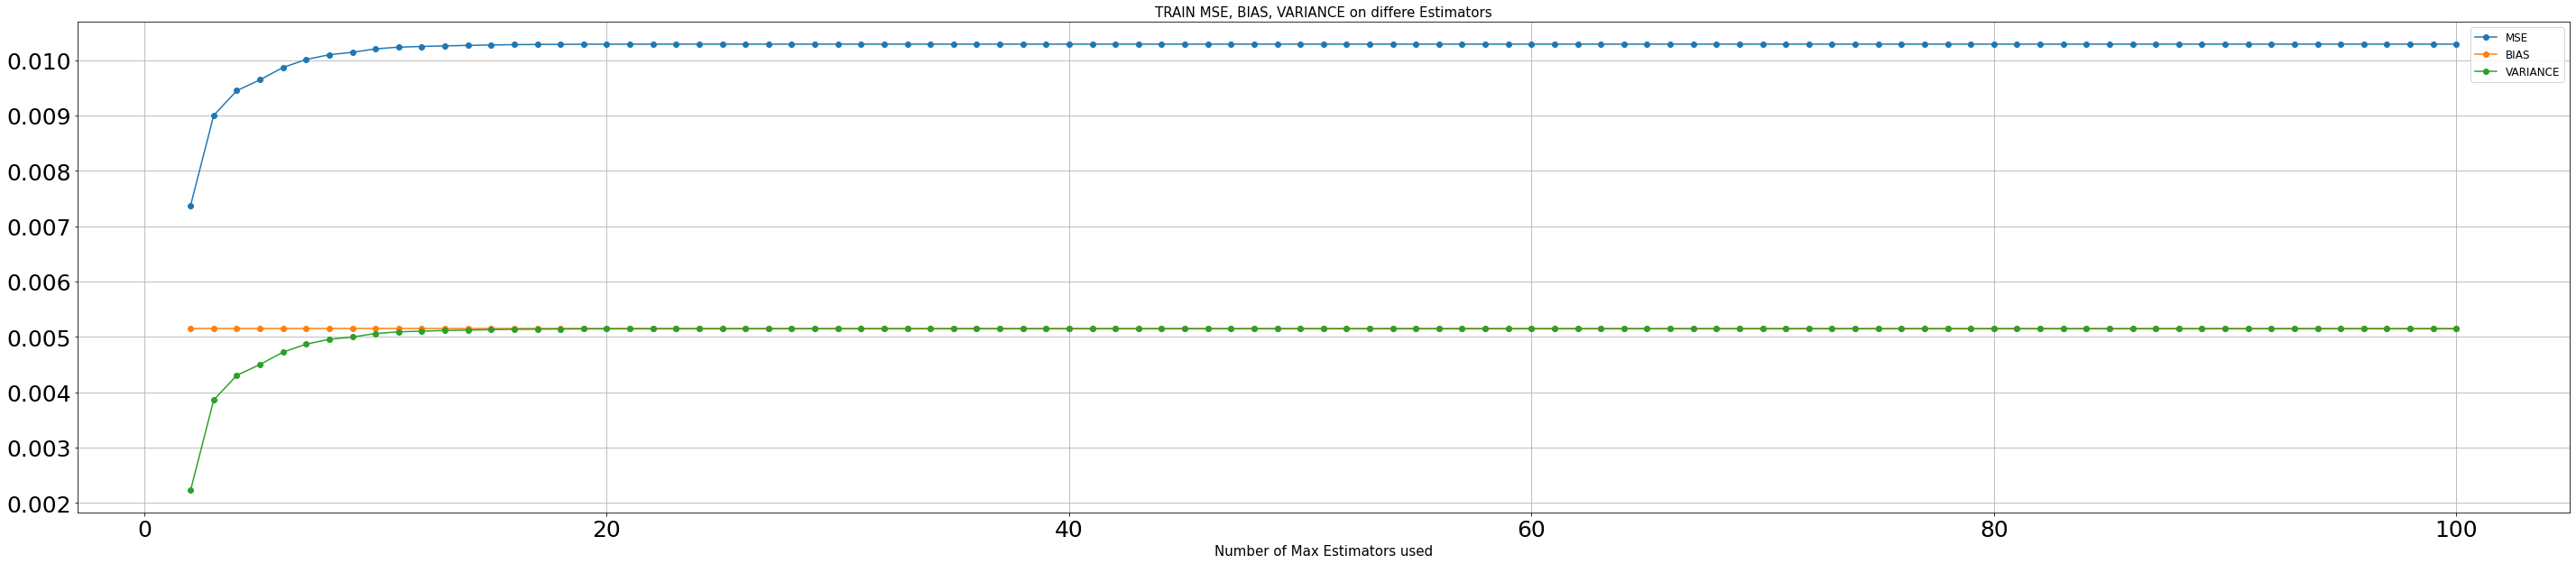

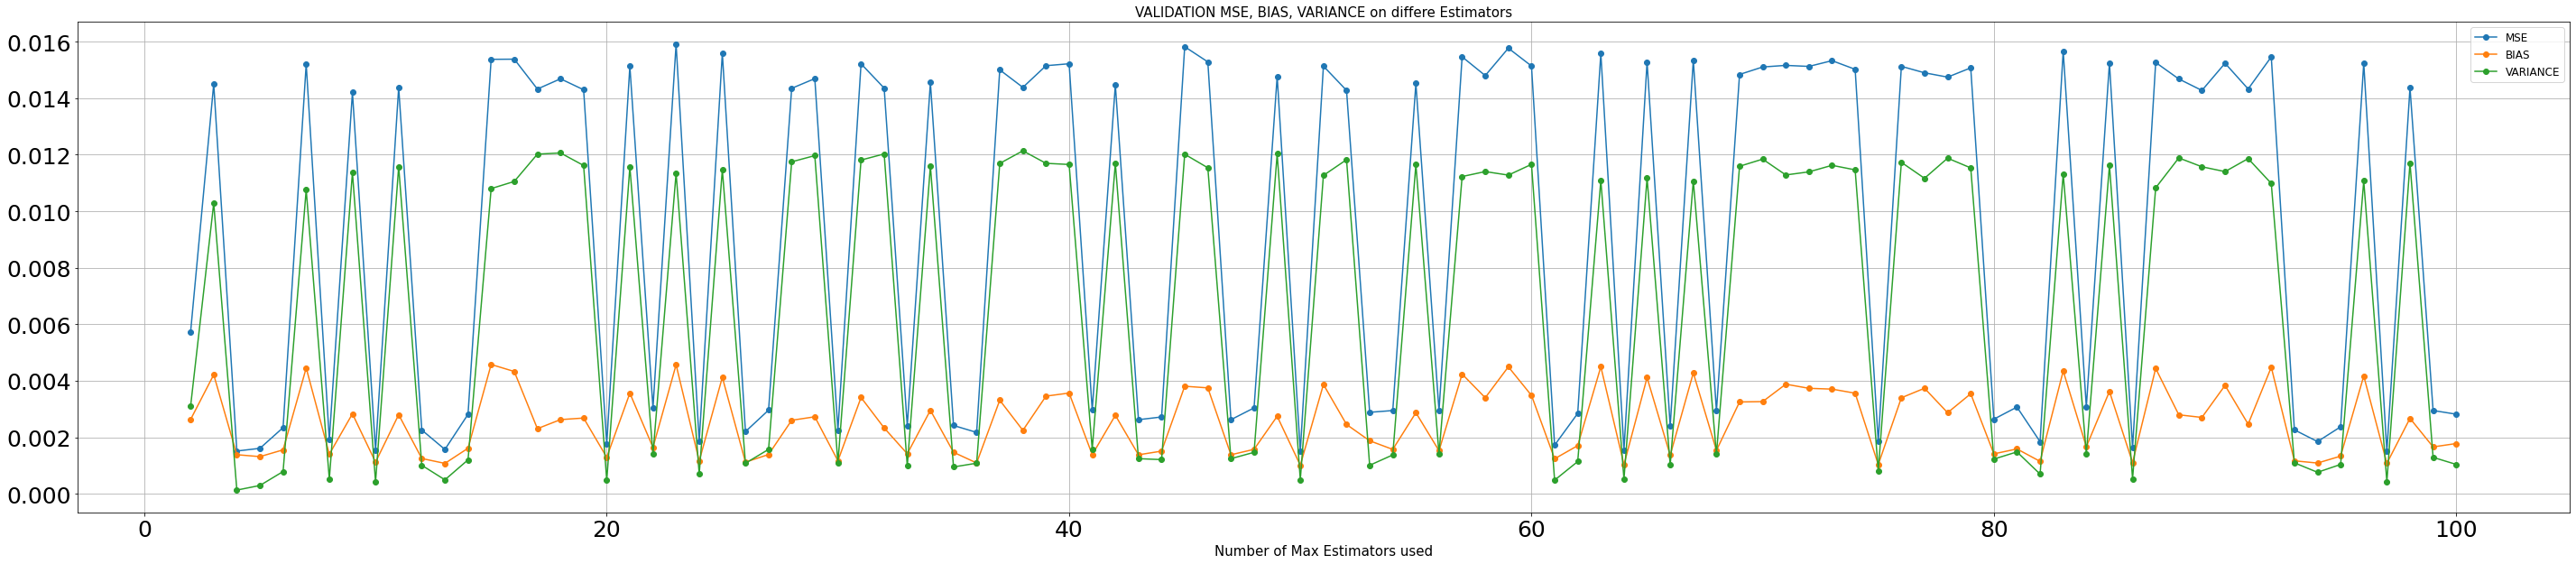

In [16]:
%%time
dt_model.append(
    get_dt(
        0,
        verbose   = False,
        debug     = False,
        file_name = 'A'
    )
)

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.01028986202383009 (100) stimatori
Best mse: 0.007374927903322706
Best number of Estimators: 2

Punteggio finale: 0.005144931011915045 (100) stimatori
Best bias: 0.005144931011915044
Best number of Estimators: 19

Punteggio finale: 0.005144931011915045 (100) stimatori
Best var: 0.0022299968914076583
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.01499186815858644 (100) stimatori
Best mse: 0.0013690630288405647
Best number of Estimators: 9

Punteggio finale: 0.003374398181541268 (100) stimatori
Best bias: 0.000978313081556894
Best number of Estimators: 68

Punteggio finale: 0.011617469977045165 (100) stimatori
Best var: 9.938649467659987e-05
Best number of Estimators: 3

Wall time: 2.88 s


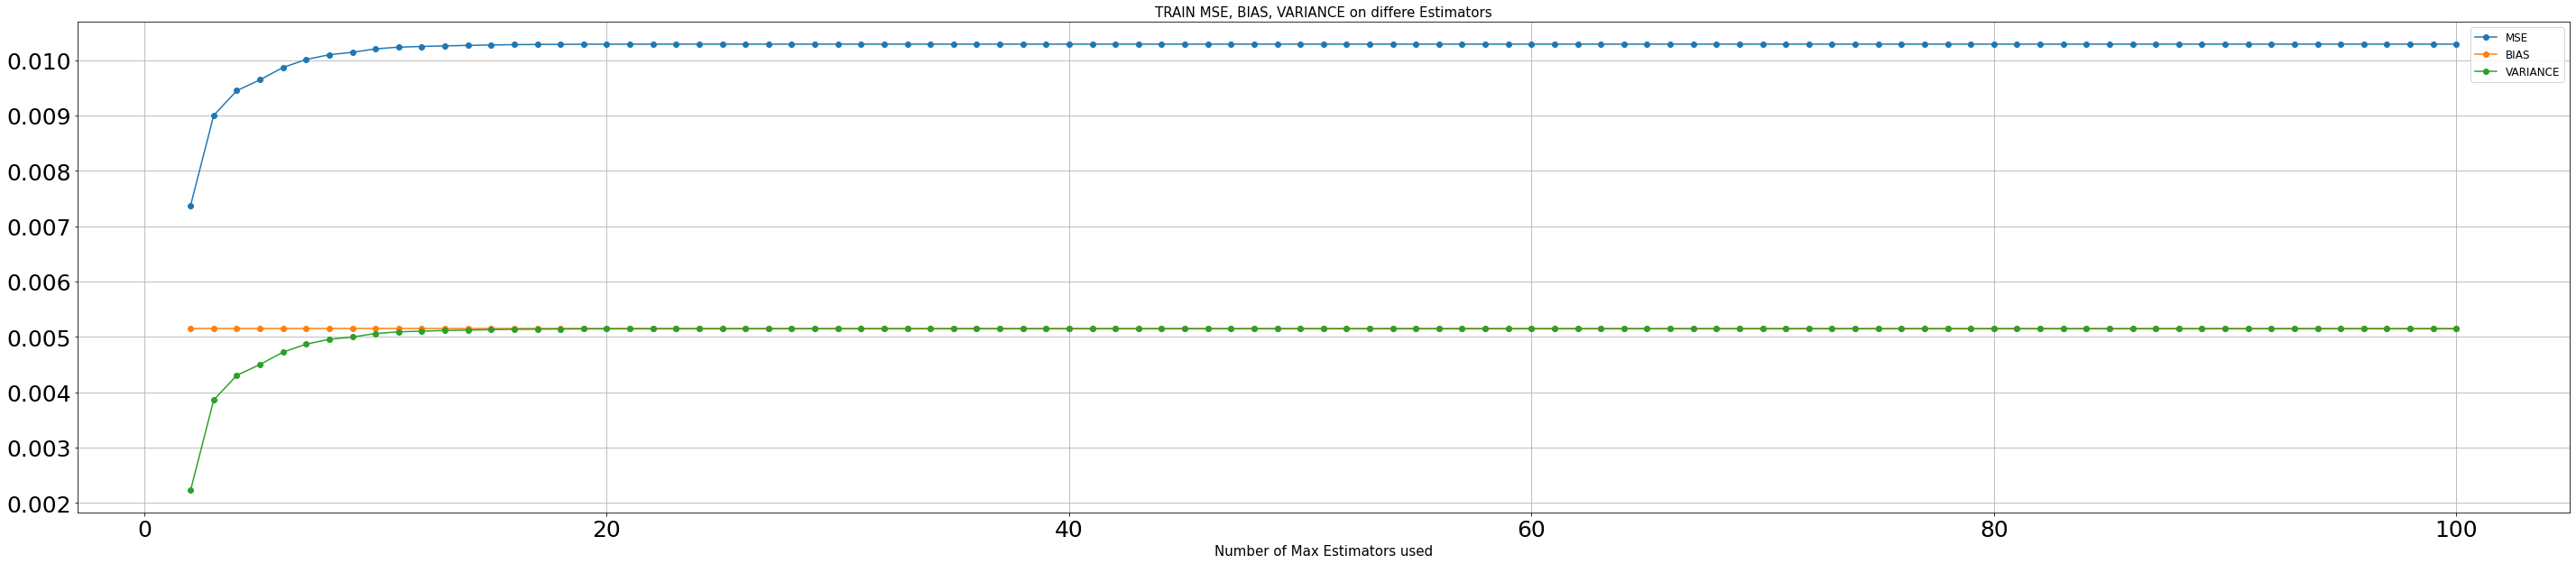

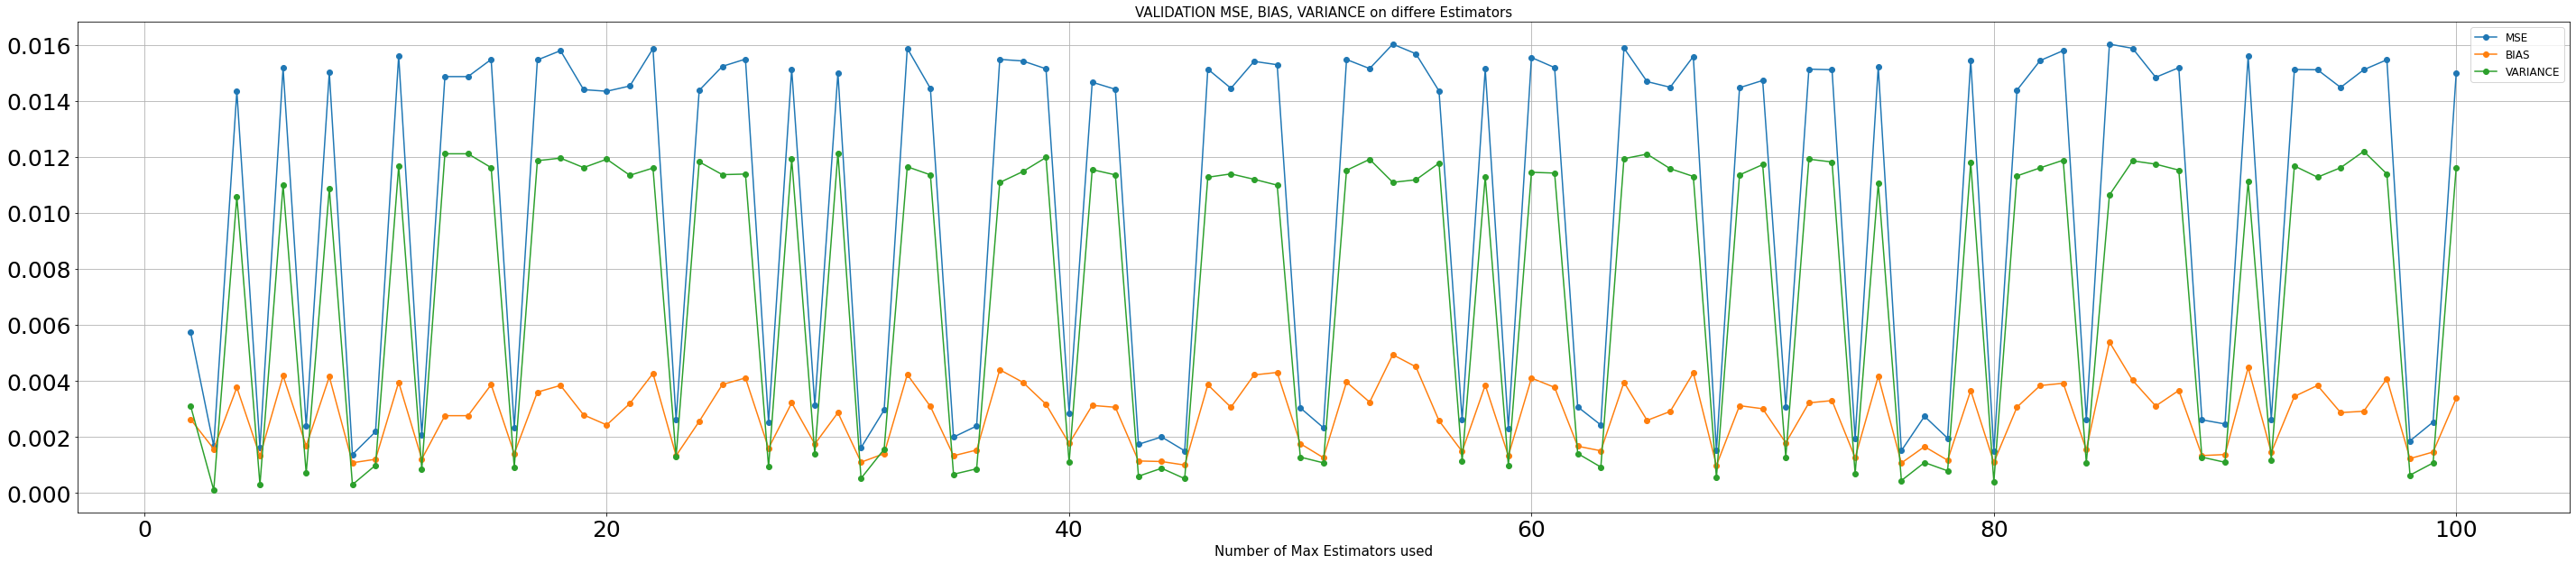

In [17]:
%%time
dt_model.append(
    get_dt(
        1,
        verbose   = False,
        debug     = False,
        file_name = 'B'
    )
)

TUNING DEL MASSIMO NUMERO DI FOGLIE TRAIN

Punteggio finale: 0.010918274120163675 (100) stimatori
Best mse: 0.007058753530167119
Best number of Estimators: 2

Punteggio finale: 0.005459137060081837 (100) stimatori
Best bias: 0.005459137060081837
Best number of Estimators: 2

Punteggio finale: 0.005459137060081837 (100) stimatori
Best var: 0.001599616470085282
Best number of Estimators: 2

TUNING DEL MASSIMO NUMERO DI FOGLIE VALIDATION

Punteggio finale: 0.009339466136154505 (100) stimatori
Best mse: 0.005234457085422798
Best number of Estimators: 2

Punteggio finale: 0.0054490818923970345 (100) stimatori
Best bias: 0.005156770176906662
Best number of Estimators: 17

Punteggio finale: 0.0038903842437574714 (100) stimatori
Best var: 0.0
Best number of Estimators: 2

Wall time: 2.8 s


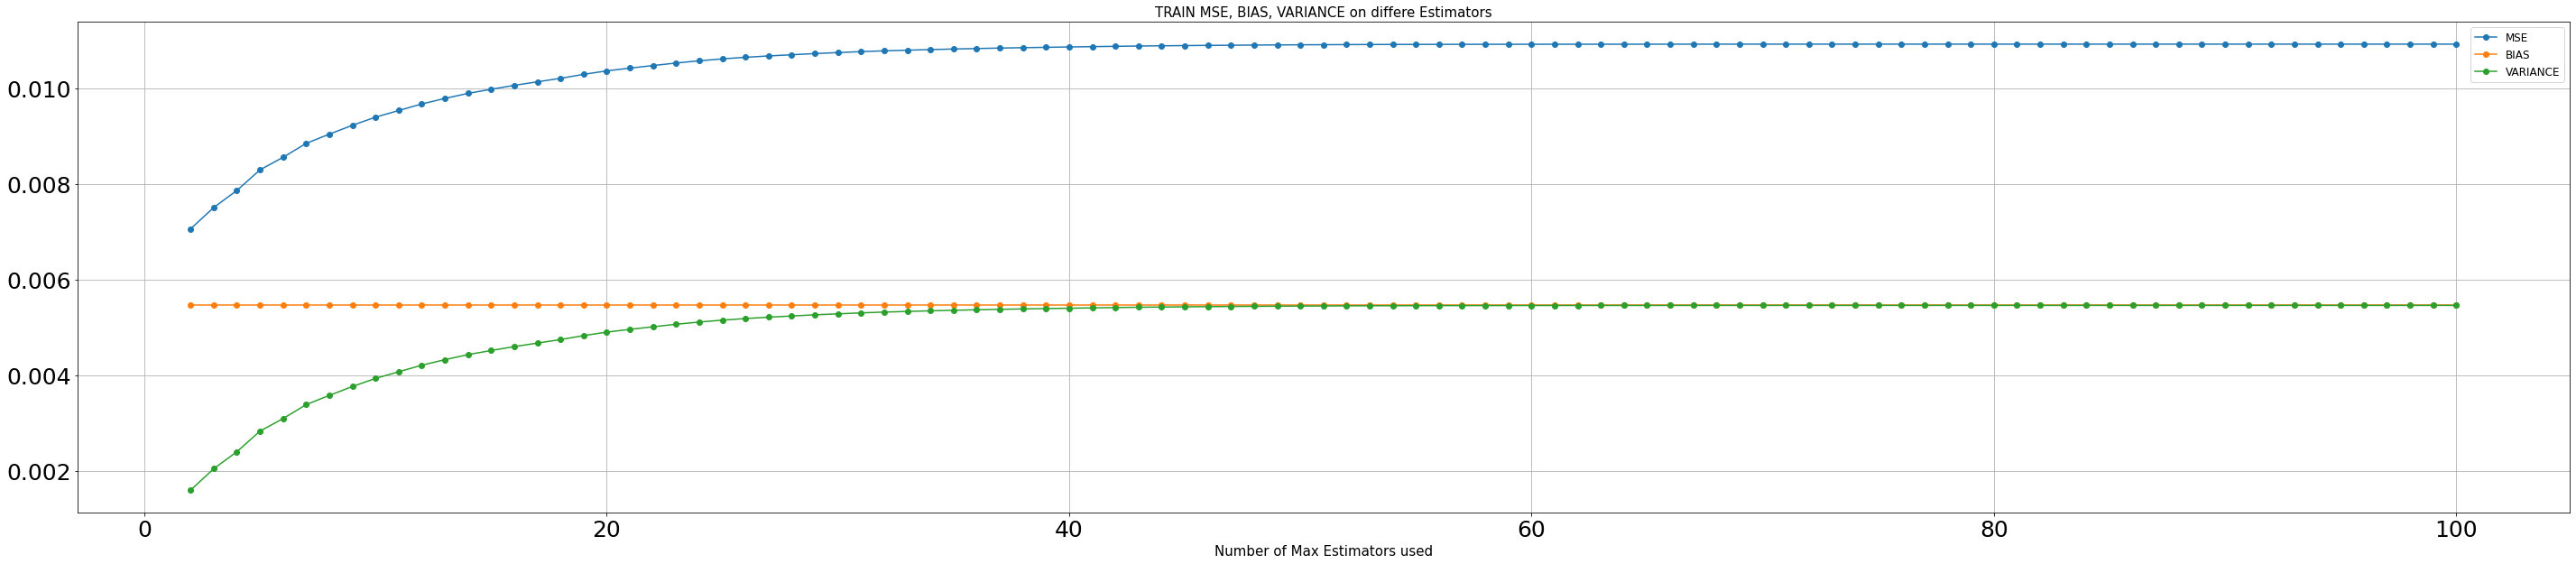

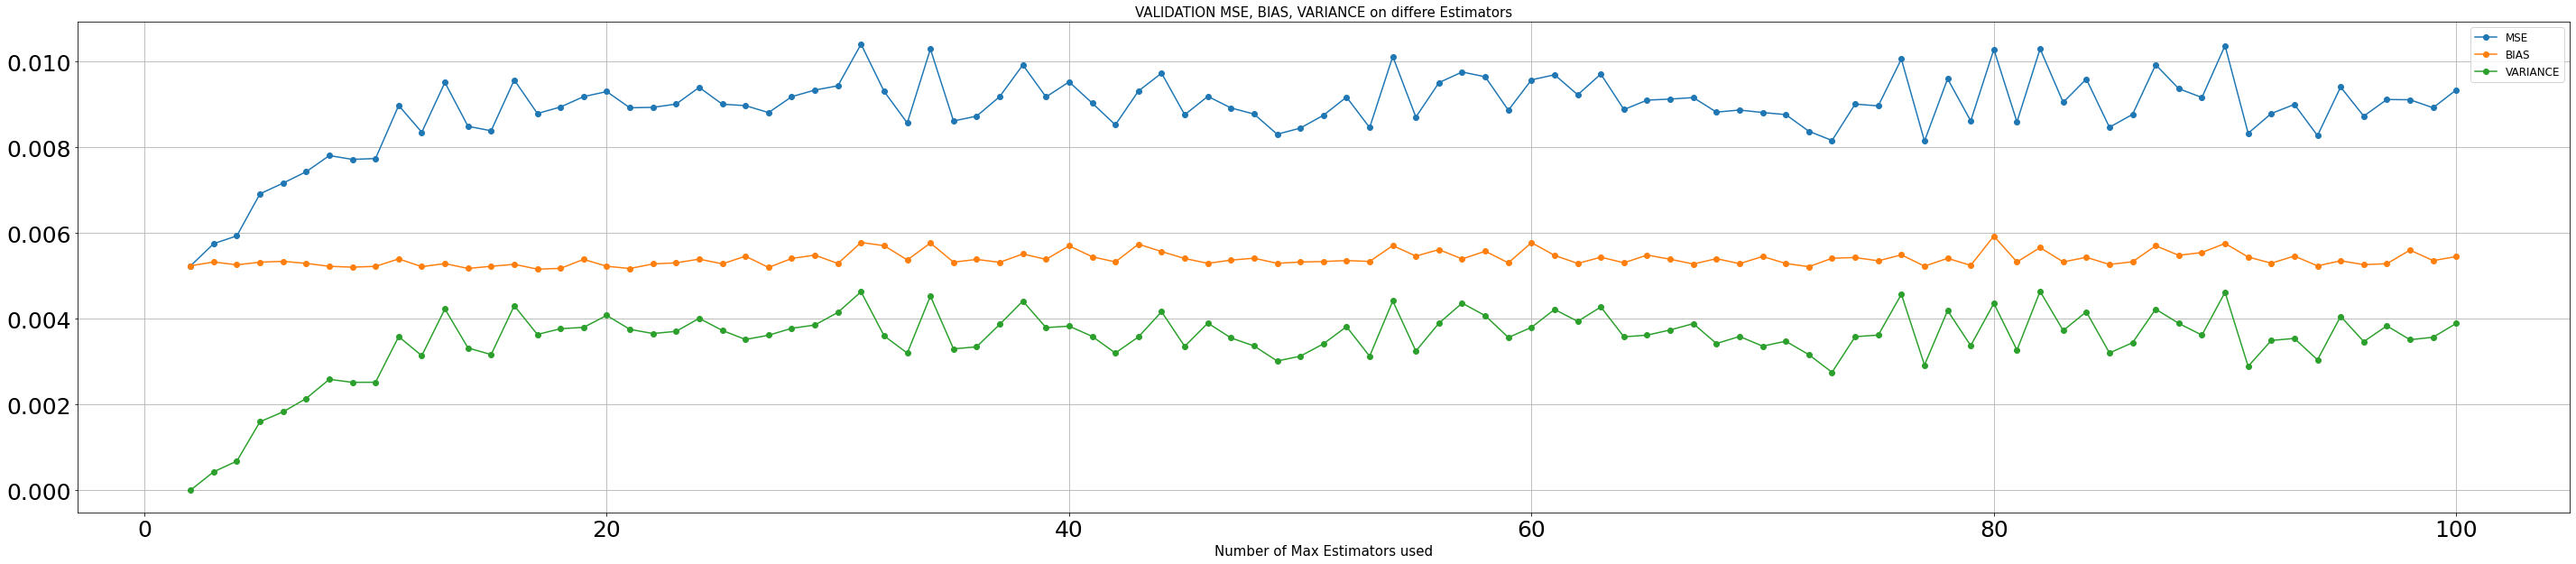

In [18]:
%%time
dt_model.append(
    get_dt(
        2,
        verbose   = False,
        debug     = False,
        file_name = 'C'
    )
)

In [21]:
dt_model

[DecisionTreeRegressor(max_leaf_nodes=97),
 DecisionTreeRegressor(max_leaf_nodes=9),
 DecisionTreeRegressor(max_leaf_nodes=2)]

In [19]:
def get_score(model, X, y):
    
    return {
        'mse'  : mean_squared_error(y_true=y,   y_pred=model.predict(X)),
        'score': model.score(X, y)
    }

In [20]:
# Train
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_train[i], y_train[i]))
    print()

A
{'mse': 0.009289366254055994, 'score': -0.3405800467565525}

B


ValueError: X has 34 features, but DecisionTreeRegressor is expecting 41 features as input.

In [ ]:
# Validation
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_val[i], y_val[i]))
    print()

In [ ]:
# Test
for i in range(3):
    print(region_names[i])
    print(get_score(dt_model[i], X_test[i], y_test[i]))
    print()

Da dove proviene l'errore?

In [ ]:
for i in range(2): #range(3)
    print(region_names[i])
    print('Train     ', get_bias_var_mse(X_train[i], y_train[i].values.ravel(), dt_model[i]))
    print('Validation', get_bias_var_mse(X_val  [i], y_val  [i].values.ravel(), dt_model[i]))    
    print('Test      ', get_bias_var_mse(X_test [i], y_test [i].values.ravel(), dt_model[i]))  
    print()
    
print(region_names[2])
print('Train     ', get_bias_var_mse(X_train[2][:30000], y_train[2].values.ravel()[:30000], dt_model[2]))
print('Validation', get_bias_var_mse(X_val  [2],         y_val  [2].values.ravel(),         dt_model[2]))    
print('Test      ', get_bias_var_mse(X_test [2],         y_test [2].values.ravel(),         dt_model[2]))  
print()

L'errore sembra provenire principalmente dal bias: uso il boosting per ridurlo 

# Boosting #

In [ ]:
def boosting_train(X_train, y_train, X_val, y_val, baseModel, verbose=False, debug=False, file_name=''):
    
    def get_adaboost_regressor(Xs, ys, estimators):
        adaboost = AdaBoostRegressor(baseModel, n_estimators=estimators)
        adaboost.fit(Xs,ys)
        return adaboost
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'TUNING DEL NUMERO DI STIMATORI {name}')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = np.argmin(stats[n]) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) stimatori')
            print (f'Best {n}:, {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f'{name}: MSE, BIAS, VARIANCE on different Estimators', fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_' + name + '_boosting.jpg')
        
    
    START       = 1
    END         = 30
    N_TESTS     = 20
    SAMPLE_PERC = 2/3 # 0.67
    
    stats   = np.array([])
    boosts  = range(START, END)
    
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()
    
    X_start, y_start = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))
    
    model_start = get_adaboost_regressor(X_start, y_start, START)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_estimators = START
    best_model      = model_start
    
    info = []
    
    train_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }

    val_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    for b in boosts:
        
        if debug:
            print(f'{b}/{END}'')
            
        train_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        }

        val_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        } 
        
        
        # Resampling
        for i in range(N_TESTS):
            
            X_sample, y_sample = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))

            ada = get_adaboost_regressor(X_sample, y_sample, b)
            
            trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, ada)
            val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, ada)

            train_stats_s['bias'].append(trn_bias)
            train_stats_s['var' ].append(trn_var )
            train_stats_s['mse' ].append(trn_mse )
            
            val_stats_s  ['bias'].append(val_bias)
            val_stats_s  ['var' ].append(val_var )
            val_stats_s  ['mse' ].append(val_mse )
            
        train_stats_s['bias'] = np.array(train_stats_s['bias'])
        train_stats_s['var' ] = np.array(train_stats_s['var' ])
        train_stats_s['mse' ] = np.array(train_stats_s['mse' ])
        val_stats_s  ['bias'] = np.array(  val_stats_s['bias'])
        val_stats_s  ['var' ] = np.array(  val_stats_s['var' ])
        val_stats_s  ['mse' ] = np.array(  val_stats_s['mse' ])
            
        train_stats['bias'].append(train_stats_s['bias'].mean())
        train_stats['var' ].append(train_stats_s['var' ].mean())
        train_stats['mse' ].append(train_stats_s['mse' ].mean())
            
        val_stats  ['bias'].append(val_stats_s  ['bias'].mean())
        val_stats  ['var' ].append(val_stats_s  ['var' ].mean())
        val_stats  ['mse' ].append(val_stats_s  ['mse' ].mean())
         
        info.append (
            f'Estimators: {b}' +\
            f"\n(Train MSE:      {train_stats['mse' ][-1]} - Val MSE:      {val_stats['mse' ][-1]})" +\
            f"\n(Train Bias:     {train_stats['bias'][-1]} - Val Bias:     {val_stats['bias'][-1]})" +\
            f"\n(Train Variance: {train_stats['var' ][-1]} - Val Variance: {val_stats['var' ][-1]})"
        )
        
        if(val_stats['mse'][-1] < best_mse):
            best_mse = val_stats['mse'][-1]
            best_estimators = b
            best_model = ada
            
    if verbose:
        print(*info, sep='\n')
        
    plot_mse(train_stats, 'TRAIN')
    plot_mse(val_stats, 'VALIDATION') 
    
    return best_model

In [ ]:
boost_model = []

In [ ]:
def get_bmodel(index, verbose=False, debug=False, file_name=''):
    return boosting_train(
        X_train_sub [index],\
        y_train_sub [index],\
        X_val_sub   [index],\
        y_val_sub   [index],\
        dt_model[index],\
        verbose   = verbose,\
        debug     = debug,\
        file_name = file_name
    )

In [ ]:
boost_model.append(
    get_bmodel(
        0,
        verbose   = False,
        debug     = False,
        file_name = 'A'
    )        
)

In [ ]:
boost_model.append(
    get_bmodel(
        1,
        verbose   = False,
        debug     = False,
        file_name = 'B'
    )        
)

In [ ]:
boost_model.append(
    get_bmodel(
        2,
        verbose   = False,
        debug     = False,
        file_name = 'C'
    )        
)

In [ ]:
boost_model

In [ ]:
# Train
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_train[i], y_train[i]))
    print()

In [ ]:
# Validation
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_val[i], y_val[i]))
    print()

In [ ]:
# Test
for i in range(3):
    print(region_names[i])
    print(get_score(boost_model[i], X_val[i], y_val[i]))
    print()